In [1]:
%load_ext autoreload
%autoreload 2
    
from pathlib import Path
import metapack as mp
import geopandas as gpd
import pandas as pd
from auto_tqdm import tqdm 
from shapely.wkt import loads
from shapely.geometry import Polygon
import libgeohash as gh 

doc = mp.jupyter.open_source_package()
doc.set_sys_path()
import pylib

ea_epsg = 2163 #US Equal Area projection

import logging
logging.basicConfig()

from pylib import lines_logger, points_logger
lines_logger.setLevel(logging.DEBUG)
points_logger.setLevel(logging.DEBUG)

pkg_root = Path(doc.path).parent
pkg = mp.open_package(pkg_root)
pkg

# Open Street Map Extract for Demographic Search
`civicknowledge.com-osm-demosearch-1.1.3` Last Update: 2021-02-06T17:04:58

__




 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [geohash_tags](data/geohash_tags.csv)**. Points converted to counts of tags per geohash
* ** [residential_roads](data/residential_roads.csv)**. Residential roads per 4 digit geohash
* ** [nonres_roads](data/nonres_roads.csv)**. Non residential roads per 4 digit geohash

## References
<ul><li> <strong>us_geohashes</string>, <em>metapack+http://library.metatab.org/civicknowledge.com-geohash-us.csv#us_geohashes</em>. All 4 digit geohases in the continential US</li><li> <strong><a href="https://download.geofabrik.de/north-america-latest.osm.pbf">north-america-latest</a></strong>. OSM North America extract</li><li> <strong>points</string>, <em>data/csv/points.csv</em>. Points from the OSM file</li><li> <strong>lines</string>, <em>data/csv/lines.csv</em>. Lines from the OSM file</li><li> <strong>multipolygons</string>, <em>data/csv/multipolygons.csv</em>. Polygons from the OSM file</li><li> <strong>multilinestrings</string>, <em>data/csv/multilinestrings.csv</em>. Lines from the OSM file</li><li> <strong>other_relations</string>, <em>data/csv/other_relations.csv</em>. Other geo data from the OSM file</li><ul>

In [2]:
cache = pylib.open_cache(pkg)

In [3]:
pkg_h = mp.open_package('http://library.metatab.org/civicknowledge.com-geohash-us.csv')
hashes = pkg_h.resource('us_geohashes').geoframe().rename(columns={'geohash':'gh4'})


In [4]:
roads = pkg.

In [140]:
cont_tags = hashes[['gh4']].merge(tags_df) # only in the continential US
ts = cont_tags.set_index('geohash')[['amenity','shop','tourism']].stack().to_frame().reset_index()
ts.columns = ['geohash','group','type']
ts['dummy'] = 1

In [141]:
ts

,geohash,group,type,dummy
0,djyppgvv0vee,amenity,school,1
1,djypw436rgpt,amenity,school,1
2,djyp6v1e8vr8,amenity,place_of_worship,1
3,djypcn4kczw7,amenity,place_of_worship,1
4,djyp3ud2hpv9,amenity,school,1
...,...,...,...,...
1468571,dn0z138wkmws,amenity,place_of_worship,1
1468572,dn0z3pr9sne0,amenity,townhall,1
1468573,dn0zmpd19q4r,tourism,camp_site,1
1468574,dn0zmph68rnu,amenity,ranger_station,1


In [131]:
ts.type.value_counts().head(30)

place_of_worship    182597
restaurant          128827
bench               116910
school              101657
grave_yard           79031
fast_food            73839
bicycle_parking      50282
fuel                 44465
parking              43034
convenience          37799
waste_basket         36475
information          35387
cafe                 34243
toilets              33745
post_box             32773
clothes              28985
camp_site            25727
bank                 25026
parking_entrance     24346
hairdresser          21589
supermarket          20189
fountain             19689
post_office          18460
camp_pitch           18211
fire_station         18199
viewpoint            18119
artwork              17904
pharmacy             17442
drinking_water       17176
beauty               16928
Name: type, dtype: int64

In [148]:
low_dens_tags = ['grave_yard','camp_site','camp_pitch','bench','view_point']

count    13548.000000
mean        13.913282
std         15.999727
min          3.000000
25%          4.000000
50%          8.000000
75%         16.000000
max         80.433274
Name: dummy, dtype: float64

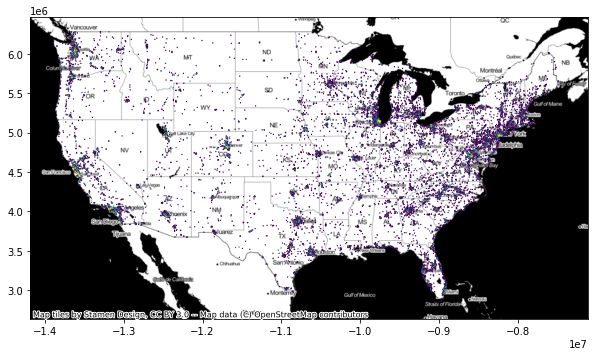

In [187]:
import contextily as ctx

bus_tags = ['restaurant','fast_food','cafe','convenience','bank','supermarket']

t = ts[ts.type.isin(bus_tags)]
t = t.groupby(t.geohash.str.slice(0,5)).dummy.count().to_frame().reset_index()
t['geometry'] = t.geohash.apply(lambda ghc: Polygon([ele[::-1] for ele in gh.bbox(ghc, coordinates = True)]))
t = gpd.GeoDataFrame(t, crs=4326).to_crs(3857) # Web Mercator
t = t[t.dummy >2]
t['dummy'] = t.dummy.clip(0,t.dummy.mean()*5)
t['geometry'] = t.buffer(5000)
ax =t.plot(column='dummy', scheme='fisher_jenks_sampled',figsize=(10, 8))
ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner)
display(t.dummy.describe())

In [184]:
t.describe()

,dummy
count,6389.000000
mean,26.755372
std,57.065830
min,1.000000
25%,2.000000
50%,6.000000
75%,20.000000
max,292.595398


In [178]:
gh.dimensions(t.iloc[0].geohash[0:5])

(4900, 4900)